# Recognition of faces from Inception Resnet V1 

## Imports

In [1]:
import cv2
import numpy as np
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import faiss
import os

## Face Detection through MTCNN

In [2]:
# Face detector
device='cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=True, device=device)
device

'cpu'

## Face Recognition through Facenet pre-trained model

In [3]:
# Face recognition model (FaceNet pre-trained)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

def extract_face(image, mtcnn, target_size=(160, 160)):
    """
    Detects and crops the face from the image.
    """
    boxes, _ = mtcnn.detect(image)
    if boxes is None:
        return None
    cropped_faces = []
    for box in boxes:
        x1, y1, x2, y2 = [int(b) for b in box]
        face = image[y1:y2, x1:x2]
        face_resized = cv2.resize(face, target_size)
        cropped_faces.append(face_resized)
    return cropped_faces

In [4]:
def encode_faces(faces, facenet):
    """
    Generates embeddings for detected faces.
    """
    embeddings = []
    for face in faces:
        # Convert to PyTorch tensor
        face = torch.tensor(face.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
        embedding = facenet(face).detach().numpy()
        embeddings.append(embedding)
    return np.vstack(embeddings)

### Building the database

In [5]:
def build_face_database(image_folder, mtcnn, facenet):
    """
    Creates a database of known faces from images in the given folder.
    """
    database = {}
    for file in os.listdir(image_folder):
        name, ext = os.path.splitext(file)
        if ext.lower() not in ['.jpg', '.png']:
            continue
        image = cv2.imread(os.path.join(image_folder, file))
        faces = extract_face(image, mtcnn)
        if faces:
            embeddings = encode_faces(faces, facenet)
            database[name] = embeddings[0]
    return database

# Load known faces
database = build_face_database("known_faces", mtcnn, facenet)


## FAISS Search

In [6]:
def recognize_faces_faiss(input_image, database, mtcnn, facenet, threshold=0.6):
    """
    Recognizes faces in the input image by comparing with the database using FAISS.
    
    Parameters:
    - input_image: The image to process.
    - database: A dictionary of precomputed embeddings (name -> embedding).
    - mtcnn: The face detector.
    - facenet: The face recognition model.
    - threshold: Similarity threshold for recognition.
    
    Returns:
    - Annotated image with recognition results.
    """
    # Extract and crop faces
    faces = extract_face(input_image, mtcnn)
    if not faces:
        return input_image, []

    # Generate embeddings for detected faces
    embeddings = encode_faces(faces, facenet)
    
    # Prepare FAISS index
    # Convert database to a format suitable for FAISS
    db_embeddings = np.array(list(database.values())).astype('float32')
    db_names = list(database.keys())
    
    # Create FAISS index for L2 similarity (use IndexFlatIP for cosine similarity)
    index = faiss.IndexFlatIP(db_embeddings.shape[1])  # Inner Product for cosine similarity
    faiss.normalize_L2(db_embeddings)  # Normalize embeddings for cosine similarity
    index.add(db_embeddings)

    
    # Normalize face embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Search database for nearest matches
    distances, indices = index.search(embeddings, 1)  # Top-1 match for each embedding

    results = []
    for dist, idx in zip(distances[:, 0], indices[:, 0]):
        if dist > threshold and idx < len(db_names):
            results.append((db_names[idx], dist))
        else:
            results.append((None, dist))
    
    # Annotate image
    annotated_image = input_image.copy()
    for (box, (name, score)) in zip(mtcnn.detect(input_image)[0], results):
        x1, y1, x2, y2 = [int(b) for b in box]
        label = f"{name} ({score:.2f})" if name else "Unknown"
        color = (0, 255, 0) if name else (0, 0, 255)
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)
    
    return annotated_image, results

### Runner Code

[('Abdullah_Gul_0018', 0.79134274)]


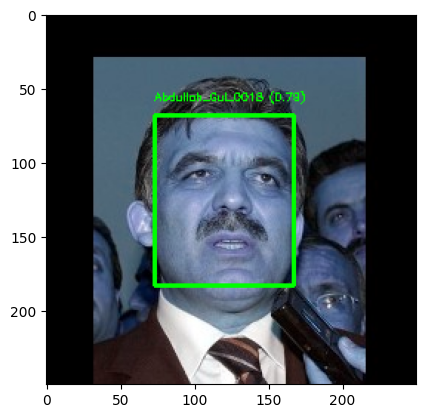

In [ ]:
input_image_path = "test images/Abdullah_Gul_0010.jpg"

# Process a test image
input_image = cv2.imread(input_image_path)

annotated_image_faiss, results_faiss = recognize_faces_faiss(input_image, database, mtcnn, facenet)
print(results_faiss)
plt.imshow(annotated_image_faiss)